In [1]:
import numpy as np
import commpy as cp
from commpy.channelcoding import Trellis
from commpy.modulation import QAMModem, PSKModem

import utils as utils
from signal_generator import SignalGenerator
from baseline_receiver import BaselineReceiver
from modular_receiver import ModularReceiver

# Visualization
import pylab
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()  # Use seaborn as backend of matplotlib for vis

## Define Paramters for the comparison

In [2]:
# For encoding/decoding convolutional codes
G = np.array([[0o7, 0o5]]) 
M = np.array([2])
trellis = Trellis(M, G, feedback=0o7, code_type='rsc')

class Params:
    SNR_RANGE = range(0, 40, 5)
    NUM_SAMPLES = 1000
    BLOCK_LENGTH = 100
    BPSK, QPSK, QAM16, QAM64 = 2, 4, 16, 64
    
modem = QAMModem(m=Params.QAM64)
signal_generator = SignalGenerator(modem=modem)

## Define Baseline (Demod + Viterbi) & Modular Receivers (NN + RNN)

In [3]:
baseline_receiver = BaselineReceiver(modem, trellis)
modular_receiver = ModularReceiver(
    num_classes=modem.m,
    demod_model_path='demod_model.hdf5')

Cannot load demod model weights. Pass


## Evaluate Baseline  on multiple SNRs

100%|██████████| 8/8 [00:25<00:00,  3.15s/it]


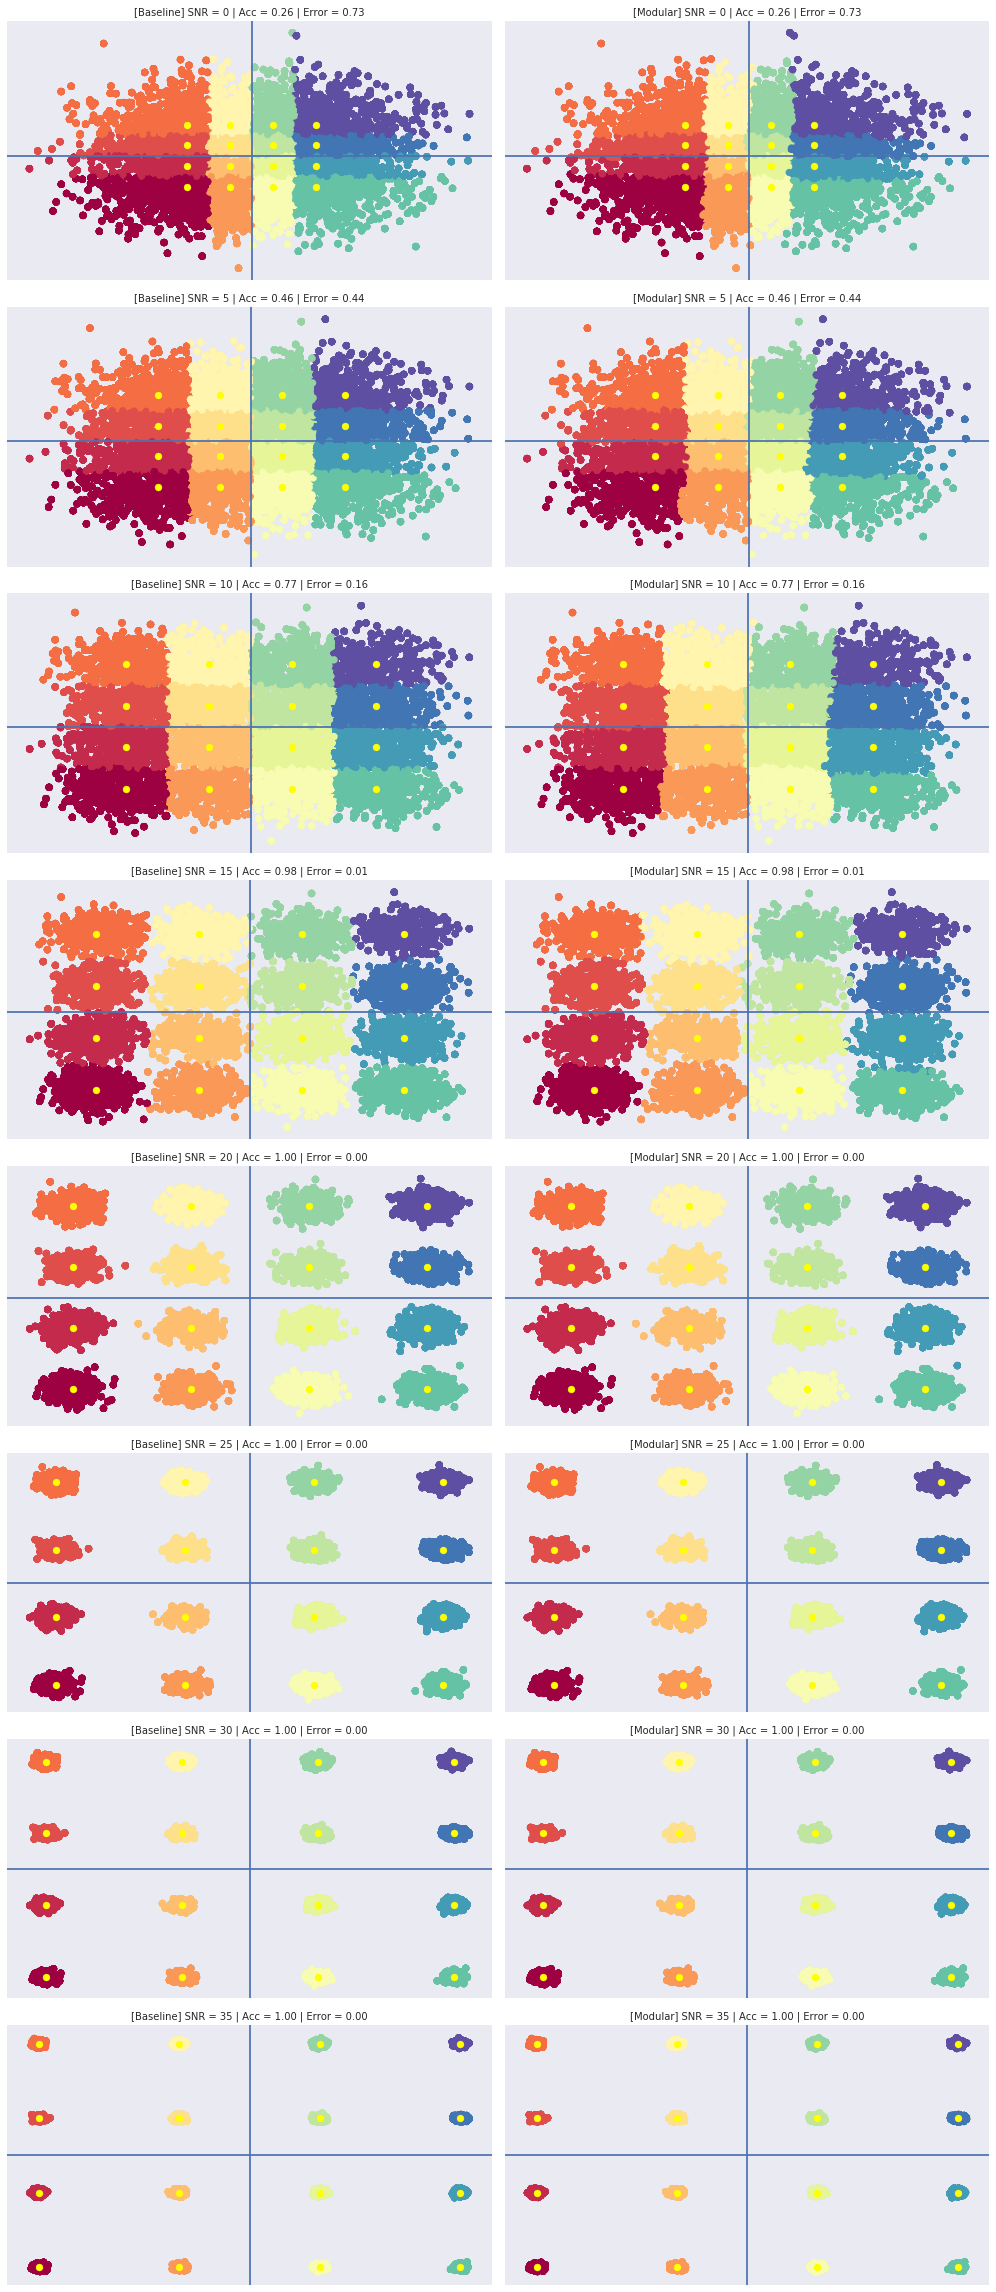

In [8]:
import tqdm

errors_logs = []
accuracies_logs = []

fig, axes = plt.subplots(len(Params.SNR_RANGE), 2, figsize=(14, 4 * len(Params.SNR_RANGE)))
for i, snr in tqdm.tqdm(enumerate(Params.SNR_RANGE), total=len(Params.SNR_RANGE)):
    (original_bits, clean_signals, noisy_signals) = signal_generator(
        Params.NUM_SAMPLES, 
        Params.BLOCK_LENGTH, 
        snr_in_dB=snr)
    complex_inputs = noisy_signals.flatten()
    _, ground_truths = np.unique(clean_signals.flatten(), return_inverse=True)

    # ####################################
    # Run Baseline/Neral Demod
    # ####################################
    baseline_predictions = baseline_receiver.demodulate(complex_inputs)
    nn_predictions       = modular_receiver.demodulate(complex_inputs)

    # ####################################
    # Measure Accuracy / error
    # ####################################
    acc, err       = utils.get_scores(baseline_predictions, ground_truths)    
    nn_acc, nn_err = utils.get_scores(nn_predictions, ground_truths)

    # ####################################
    # Visualize Constellation
    # ####################################
    title    = '[Baseline] SNR = {} | Acc = {:.2f} | Error = {:.2f}'.format(snr, acc, err)
    nn_title = '[Modular] SNR = {} | Acc = {:.2f} | Error = {:.2f}'.format(snr, nn_acc, nn_err)

    utils.visualize_demodulation(complex_inputs, modem.constellation, ax=axes[i, 0],
        predictions=baseline_predictions,
        title=title)

    utils.visualize_demodulation(complex_inputs, modem.constellation, ax=axes[i, 1],
        predictions=nn_predictions,
        title=nn_title)
    
    errors_logs.append([err, nn_err])
    accuracies_logs.append([acc, nn_acc])

fig.tight_layout()

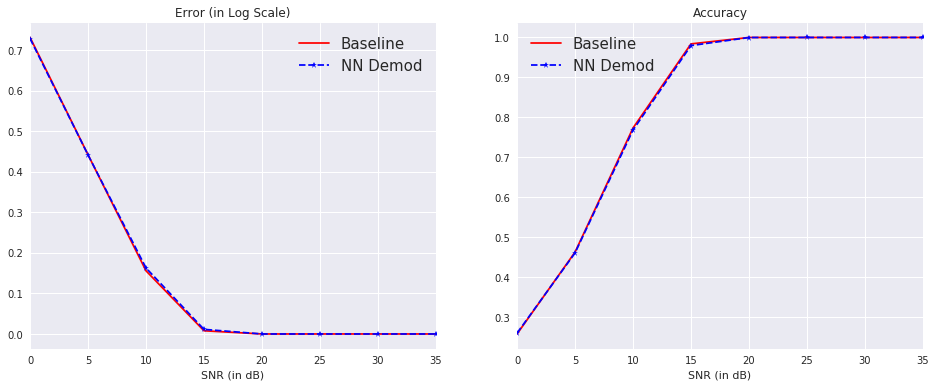

In [9]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
utils.visualize_acc_err(ax1, ax2, errors_logs, accuracies_logs, Params.SNR_RANGE)

## Evaluate Decode

In [15]:
clean_signals

array([[-3.+3.j, -1.-1.j, -3.+1.j, ...,  1.+1.j, -1.+3.j, -3.-3.j],
       [ 3.-1.j,  1.-1.j, -3.-1.j, ..., -1.+1.j,  1.-1.j, -3.-1.j],
       [ 3.+1.j,  3.+3.j, -1.-1.j, ...,  3.-3.j, -3.+3.j, -1.-1.j],
       ...,
       [ 3.-1.j,  1.-1.j, -3.+1.j, ...,  3.-1.j, -1.-3.j, -1.-1.j],
       [ 3.-1.j,  1.-1.j, -3.+1.j, ..., -3.-3.j,  3.+1.j, -3.-1.j],
       [-3.+3.j,  1.+3.j,  3.+1.j, ..., -3.-1.j,  1.-1.j, -3.-1.j]])